# Dataset real

## 1) Preparação do ambiente

In [17]:
import re, string
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
nltk.download('stopwords') 
nltk.download('rslp')

import spacy
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from unidecode import unidecode

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from itertools import chain
nlp = spacy.load("pt_core_news_sm")

PT_STOPWORDS = set(stopwords.words("portuguese"))
STEMMER = RSLPStemmer()

plt.rcParams["figure.figsize"] = (7,4)
print("Ambiente pronto!")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/siqueira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /home/siqueira/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


Ambiente pronto!


## 2) Carregamento e análise exploratória dos dados


In [18]:
df_general = pd.read_csv('selected_crimes.csv')
df_general.head()

,unidade_origem,unidade_responsavel,dia_semana,mes_fato,ano_fato,data_fato,consolidado,especificacao_crime,causa_presumivel,meio_empregado_sisp,...,vit_fx_etaria,vit_sexo,vit_cor_pele,vit_grau_inst,grau_de_relacionamento,relato,aut_sexo,turno,periodo,consolidado_stratified
0,Nao informado,Nao informado,SEX,JUNHO,2021,2021-06-04,AMEACA,Nao informado,ÓDIO OU VINGANÇA,OUTROS MEIOS,...,IDOSO (65 ANOS OU MAIS),F,PREJUDICADO,ENSINO MEDIO COMPLETO,NAO INFORMADO,"<P>A&NBSP;COMUNICANTE ACIMA QUALIFICADA&NBSP;COMPARECEU NESSA CENTRAL DE POLICIA DE SAO BRAS PARA INFORMAR QUE NA HORA, DATA E LOCAL ACIMA CITADOS FOI VITIMA DE AMEACA POR PARTE DA NACIONAL JUCELENA GOMES OLIVEIRA, ESTA RESIDIA ATE NOV/20 EM CONJUNTO COM A RELATORA, POREM ESSA MUDOU-SE PARA CAMPINAS/SP ONDE ESTA ATE O PRESENTE MOMENTO, TENDO EXPECTATIVA&NBSP;DE RETORNO PARA BELEM/PA NOS PROXIMOS DIAS AO REGISTRO DESTE B.O.P. A ACUSADA REALIZA CONSTANTES OFENSAS E AMEACAS A INTEGRIDADE FISICA DA MESMA E DE SEUS FAMILIARES, AO REIVINDICAR POSSE DO IMOVEL ONDE RESIDIU ANTERIORMENTE. REGISTRA-SE PARA OS DEVIDOS FINS DE DIREITO. ////////////////////</P>",Nao informado,TARDE,1 SEMESTRE DE 2021,AMEACA
1,CREMACAO - 4ª SECCIONAL - 1ª RISP- 3ª AISP,CREMACAO - 4ª SECCIONAL - 1ª RISP- 3ª AISP,DOM,JUNHO,2020,2020-06-21,AMEACA,Nao informado,OUTRAS,OUTROS MEIOS,...,ADULTO II (25 A 29 ANOS),F,PREJUDICADO,ENSINO FUNDAMENTAL INCOMPLETO,NAO INFORMADO,"<p>//A comunicante acima qualificada compareceu a esta Seccional Urbana para informar que no dia 21/06/2020, por volta das 12:05 estava fazendo seu alimento no fogo a lenha pos avia terminado seu&nbsp;gás, quando sua vizinha a Sra de suposto Nominal RAIMUNDA residente na PASSAGEM; CABO LEAO E/ RUA TAMBES E SANTA ANA N° 25 ALTOS ela por sua vez&nbsp;se sentiu incomodada com a fumaça e começou e começou a&nbsp;agredir verbalmente a relatora, que informa que não ser a primeira vez que acontece, e por isso veio ate esta Seccional para se fazer um B.O.P, Regista-se para fins de direito///.</p>",Nao informado,TARDE,1 SEMESTRE DE 2020,AMEACA
2,Nao informado,Nao informado,QUA,MAIO,2023,2023-05-10,ESTUPRO DE VULNERAVEL,VIOLENCIA DOMESTICA,OUTRAS,OUTROS MEIOS,...,ADULTO I (18 A 24 ANOS),F,PREJUDICADO,ENSINO MEDIO COMPLETO,PADRASTO,"<P>A RELATORA ATUALMENTE COM 21 ANOS DE IDADE, VEM A ESTA SECCIONAL COMUNICAR QUE QUANDO TINHA 14 ANOS DE IDADE, FOI ABUSADA SEXUALMENTE POR SEU PADRASTO DE PRE NOME MANOEL VULGO “AGUIA”; QUE RELATA QUE EM 2015 QUANDO TINHA A IDADE DE 14 ANOS, A RELATORA MORAVA COM SUA AVO MATERNA E UM PRIMO SEU O QUAL ERA PORTADOR DE NECESSIDADES ESPECIUAIS, EM UMA OUTRA CASA LOCALIZADA NO BAIRRO DO MARACAJA E SUA GENITORA MORAVA NO BAIRRO DO PANTANAL JUNTAMENTE COM SEU ABUSADOR O NACIONAL MANOEL VULGO “AGUIA”; QUE SUA MAE BIOLOGICA NA EPOCA, IA PARA CASA DA AVO DA RELATORA CUIDAR DO TAL PRIMO ESPECIAL, QUE ERA UMA ESPECIE DE EMPREGO DA GENITORA DA RELATORA, POIS A SUA AVO PAGA UMA CERTA QUANTIA EM DINHEIRO PARA SUA MAE; QUE MANOEL VULGO AGUIA FICAVA SOZINHO NA CASA ONDE MORAVAM NO BAIRRO DO PANTANAL; QUE EM DETERMINADO DIA DO ANO DE 2015, A MAE BIOLOGICA DA RELATORA PEDIU PARA QUE ELA (A VITIMA) FOSSE ATE A CASA ONDE ESTAVA MANOEL VULGO AGUIA PARA LEVAR UM PRATO DE COMIDA PARA ELE, O QUAL ESTAVA SOZINHO; QUE A RELATORA ENTAO FOI, CHEGANDO NO LOCAL ENCONTROU COM MANOEL E ESTE LHE DEU UM DINHEIRO E PEDIU PARA QUE A RELATORA FOSSE COMPRAR UM SUCO PARA ELE, QUE A RELATORA ENTAO FOI COMPRAR; QUE AO RETORNAR PARA A CASA ONDE ESTAVA MANOEL PARA LHE ENTREGAR O SUCO, ESTE JA ESTAVA SOMENTE DE CUECAS; QUE, MANDOU QUE A RELATORA ENTRASSE, E ASSIM QUE ELA ENTROU MANOEL A EMPURROU NO CHAO E MANDOU QUE FICASSE CALADA, TIROU A ROUPA DA RELATORA E PRATICOU SEXO COM A MESMA; QUE A RELATORA AINDA TENTOU GRITAR MAIS MANOEL AMEACOU A RELATORA DE MORTE, BEM COMO A RUA ESTAVA DESERTA; QUE APOS O ATO DE VIOLENCIA A VITIMA RETORNOU PARA CASA ONDE MORAVA COM A VO MATERNA E DESDE ENTAO A VITIMA NAO CONTOU O FATO PARA NINGUEM, POIS MANOEL VULGO AGUIA HAVIA LHE AMEACADO D

In [19]:
print('Informações sobre as tipagens e quantidade de dados do dataset:\n')
df_general.info()

print('\nQuantidade de crimes:')
df_general.value_counts('consolidado_stratified')

Informações sobre as tipagens e quantidade de dados do dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   unidade_origem          500 non-null    object
 1   unidade_responsavel     500 non-null    object
 2   dia_semana              500 non-null    object
 3   mes_fato                500 non-null    object
 4   ano_fato                500 non-null    int64 
 5   data_fato               500 non-null    object
 6   consolidado             500 non-null    object
 7   especificacao_crime     500 non-null    object
 8   causa_presumivel        500 non-null    object
 9   meio_empregado_sisp     500 non-null    object
 10  bairros                 500 non-null    object
 11  local_ocorrencia        500 non-null    object
 12  vit_fx_etaria           500 non-null    object
 13  vit_sexo                500 non-null    objec

consolidado_stratified
AMEACA                   291
LESAO CORPORAL           161
ESTUPRO DE VULNERAVEL     21
IMPORTUNACAO SEXUAL       15
VIOLENCIA PSICOLOGICA     12
Name: count, dtype: int64

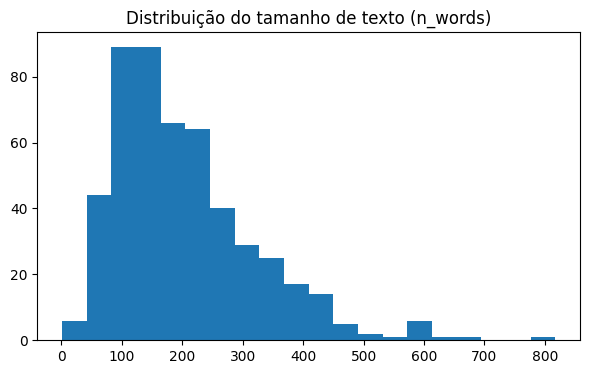

In [20]:
#Quantidade de palavras e characters nesse dataset
df_general['n_chars'] = df_general['relato'].apply(len)
df_general['n_words'] = df_general['relato'].apply(lambda x: len(x.split()))

plt.hist(df_general['n_words'], bins = 20)
plt.title('Distribuição do tamanho de texto (n_words)')
plt.show()

In [21]:
#Criação de um dataset reduzido somente com dados necessários
data = {'Classificação': df_general['consolidado_stratified'],
             'Relatos': df_general['relato'], 
             'Número de characters': df_general['n_chars'],
             'Número de palavras': df_general['n_words']} 

df_crimes = pd.DataFrame(data)

df_crimes


,Classificação,Relatos,Número de characters,Número de palavras
0,AMEACA,"<P>A&NBSP;COMUNICANTE ACIMA QUALIFICADA&NBSP;COMPARECEU NESSA CENTRAL DE POLICIA DE SAO BRAS PARA INFORMAR QUE NA HORA, DATA E LOCAL ACIMA CITADOS FOI VITIMA DE AMEACA POR PARTE DA NACIONAL JUCELENA GOMES OLIVEIRA, ESTA RESIDIA ATE NOV/20 EM CONJUNTO COM A RELATORA, POREM ESSA MUDOU-SE PARA CAMPINAS/SP ONDE ESTA ATE O PRESENTE MOMENTO, TENDO EXPECTATIVA&NBSP;DE RETORNO PARA BELEM/PA NOS PROXIMOS DIAS AO REGISTRO DESTE B.O.P. A ACUSADA REALIZA CONSTANTES OFENSAS E AMEACAS A INTEGRIDADE FISICA DA MESMA E DE SEUS FAMILIARES, AO REIVINDICAR POSSE DO IMOVEL ONDE RESIDIU ANTERIORMENTE. REGISTRA-SE PARA OS DEVIDOS FINS DE DIREITO. ////////////////////</P>",656,95
1,AMEACA,"<p>//A comunicante acima qualificada compareceu a esta Seccional Urbana para informar que no dia 21/06/2020, por volta das 12:05 estava fazendo seu alimento no fogo a lenha pos avia terminado seu&nbsp;gás, quando sua vizinha a Sra de suposto Nominal RAIMUNDA residente na PASSAGEM; CABO LEAO E/ RUA TAMBES E SANTA ANA N° 25 ALTOS ela por sua vez&nbsp;se sentiu incomodada com a fumaça e começou e começou a&nbsp;agredir verbalmente a relatora, que informa que não ser a primeira vez que acontece, e por isso veio ate esta Seccional para se fazer um B.O.P, Regista-se para fins de direito///.</p>",595,98
2,ESTUPRO DE VULNERAVEL,"<P>A RELATORA ATUALMENTE COM 21 ANOS DE IDADE, VEM A ESTA SECCIONAL COMUNICAR QUE QUANDO TINHA 14 ANOS DE IDADE, FOI ABUSADA SEXUALMENTE POR SEU PADRASTO DE PRE NOME MANOEL VULGO “AGUIA”; QUE RELATA QUE EM 2015 QUANDO TINHA A IDADE DE 14 ANOS, A RELATORA MORAVA COM SUA AVO MATERNA E UM PRIMO SEU O QUAL ERA PORTADOR DE NECESSIDADES ESPECIUAIS, EM UMA OUTRA CASA LOCALIZADA NO BAIRRO DO MARACAJA E SUA GENITORA MORAVA NO BAIRRO DO PANTANAL JUNTAMENTE COM SEU ABUSADOR O NACIONAL MANOEL VULGO “AGUIA”; QUE SUA MAE BIOLOGICA NA EPOCA, IA PARA CASA DA AVO DA RELATORA CUIDAR DO TAL PRIMO ESPECIAL, QUE ERA UMA ESPECIE DE EMPREGO DA GENITORA DA RELATORA, POIS A SUA AVO PAGA UMA CERTA QUANTIA EM DINHEIRO PARA SUA MAE; QUE MANOEL VULGO AGUIA FICAVA SOZINHO NA CASA ONDE MORAVAM NO BAIRRO DO PANTANAL; QUE EM DETERMINADO DIA DO ANO DE 2015, A MAE BIOLOGICA DA RELATORA PEDIU PARA QUE ELA (A VITIMA) FOSSE ATE A CASA ONDE ESTAVA MANOEL VULGO AGUIA PARA LEVAR UM PRATO DE COMIDA PARA ELE, O QUAL ESTAVA SOZINHO; QUE A RELATORA ENTAO FOI, CHEGANDO NO LOCAL ENCONTROU COM MANOEL E ESTE LHE DEU UM DINHEIRO E PEDIU PARA QUE A RELATORA FOSSE COMPRAR UM SUCO PARA ELE, QUE A RELATORA ENTAO FOI COMPRAR; QUE AO RETORNAR PARA A CASA ONDE ESTAVA MANOEL PARA LHE ENTREGAR O SUCO, ESTE JA ESTAVA SOMENTE DE CUECAS; QUE, MANDOU QUE A RELATORA ENTRASSE, E ASSIM QUE ELA ENTROU MANOEL A EMPURROU NO CHAO E MANDOU QUE FICASSE CALADA, TIROU A ROUPA DA RELATORA E PRATICOU SEXO COM A MESMA; QUE A RELATORA AINDA TENTOU GRITAR MAIS MANOEL AMEACOU A RELATORA DE MORTE, BEM COMO A RUA ESTAVA DESERTA; QUE APOS O ATO DE VIOLENCIA A VITIMA RETORNOU PARA CASA ONDE MORAVA COM A VO MATERNA E DESDE ENTAO A VITIMA NAO CONTOU O FATO PARA NINGUEM, POIS MANOEL VULGO AGUIA HAVIA LHE AMEACADO DE MORTE, BEM COMO HAVIA DITO QUE SE CONTASSE IRIA MATAR SUA MAE, AVO E TODA SUA FAMILIA; QUE A VITIMA ENTAO GUARDOU SEGREDO ATE NOS DIAS DE HOJE; QUE COMO DESDE DO FATO PASSOU SETE ANOS DE SUA VIDA COM ALGUNS TRAUMAS; QUE, SOMENTE NO DIA 08/05/2023 TEVE CORAGEM DE CONFIDENCIAR A VIOLENCIA SEXUAL SOFRIDA PARA UMA CONHECIDA SUA; QUE ESTA TOMOU A LIBERDADE DE FAZER A DENUNCIA E DE LHE INCENTIVAR A FORMALIZAR TAL DENUNCIA; QUE ATUALMENTE O ABUSADOR AINDA CONVIVE MARITALMENTE COM SUA MAE BIOLOGICA, POREM OS DOIS SAO USUARIOS DE DROGAS E CONVIVEM NAS RUAS; QUE SUPOE QUE O UNICO LUGAR ONDE PODERIAM ENCONTRA-LOS QUANDO NAO ESTAO NAS RUAS, SERIA EM UMA CASA QUE FICA EM UM SITIO NA LOCALIDADE DENOMINADA BAIA SANTO ANTONIO, LOCAL ONDE O UNICO MEIO DE TRANSPORTE PARA SE CHEGAR SERIA DE BARCO; QUE ATUALMENTE COM 21 ANOS DE IDADE A RELATORA, AINDA RESIDE COM SUA AVO

# 3) Limpeza do texto com REGEX

In [44]:

def clean_text(text):

    t = text.lower()
    palavras_frequentes = {'registra-se': ' ',  
                           'não': ' ',
                           'dia': ' ',
                           'acima': ' ',
                           'anos': ' ',
                           'fato': ' ',
                           'local': ' ',
                           'devidos': ' ',
                           'devidas': ' ',
                           'fins': ' ',
                           'direito': ' ',
                           'legais': ' ',
                           'providências': ' ',
                           'providencias': ' ',
                           'bairro': ' ',
                           'volta': ' ',
                           'silva': ' ',
                           'delegacia': ' ',
                           'santos': ' ',
                           'ja': ' ',
                           'data': ' '}
    for padrao, substituicao in palavras_frequentes.items():
        t = re.sub(padrao, substituicao, t)
    t = re.sub(r"(https?://\S+|www\.\S+)", ' ', t) #padrões url
    t = re.sub(r"<[^>]+>", ' ', t) #todas as tags de <>
    t = re.sub(r"/", ' ', t) #todas as ocorrências de barras 
    t = re.sub(r"&\w+;", ' ', t) #todas as ocorrências de e comercial 
    t = re.sub(r"\s+", ' ', t).strip() #casos de new line
    t = re.sub(r"\b[\w.-]+@[\w.-]+\.\w{2,}\b", ' ', t) #email
    t = re.sub(r"@\w+\b", ' ', t) #redes sociais
    t = re.sub(r"\d{3}\.*\d{3}\.*\d{3}\W*\d{2}", ' ',t) #cpf
    t = re.sub(r"\d\.?\d\.?-?\d", ' ', t) #registro geral
    t = re.sub(r"\d{2}.?\d{3}-?\d{3}", ' ', t) #cep
    t = re.sub(r"\d{1,2}\s*(?:h|horas)\b", ' ', t) #horário do tipo 16 h ou 16 horas
    t = re.sub(r"\b\d{1,2}[-/\s]\d{1,2}[-/\s]\d{1,4}\b", ' ', t) #datas
    t = re.sub(r"\d+", ' ', t)
    org_emissor_rg = {r"ssp pa": ' ', r"pc pa": ' '}
    for padrao, substituicao in org_emissor_rg.items():
        t = re.sub(padrao, substituicao, t)
    t = t.translate(str.maketrans("", "", string.punctuation)) 
    t = unidecode(t)

    return t

df_crimes['Texto limpo'] = df_crimes['Relatos'].apply(clean_text)
pd.set_option('display.max_colwidth', None) 

df_crimes.head()
#ferramentas de tratamento de texto IA ou outra biblioteca

,Classificação,Relatos,Número de characters,Número de palavras,Texto limpo,Tokens,Off stop words,Stem tokens,Lemmas tokens
0,AMEACA,"<P>A&NBSP;COMUNICANTE ACIMA QUALIFICADA&NBSP;COMPARECEU NESSA CENTRAL DE POLICIA DE SAO BRAS PARA INFORMAR QUE NA HORA, DATA E LOCAL ACIMA CITADOS FOI VITIMA DE AMEACA POR PARTE DA NACIONAL JUCELENA GOMES OLIVEIRA, ESTA RESIDIA ATE NOV/20 EM CONJUNTO COM A RELATORA, POREM ESSA MUDOU-SE PARA CAMPINAS/SP ONDE ESTA ATE O PRESENTE MOMENTO, TENDO EXPECTATIVA&NBSP;DE RETORNO PARA BELEM/PA NOS PROXIMOS DIAS AO REGISTRO DESTE B.O.P. A ACUSADA REALIZA CONSTANTES OFENSAS E AMEACAS A INTEGRIDADE FISICA DA MESMA E DE SEUS FAMILIARES, AO REIVINDICAR POSSE DO IMOVEL ONDE RESIDIU ANTERIORMENTE. REGISTRA-SE PARA OS DEVIDOS FINS DE DIREITO. ////////////////////</P>",656,95,a comunicante qualificada compareceu nessa central de policia de sao bras para informar que na hora e citados foi vitima de ameaca por parte da nacional jucelena gomes oliveira esta resi ate nov em conjunto com a relatora porem essa mudouse para campinas sp onde esta ate o presente momento tendo expectativa de retorno para belem pa nos proximos s ao registro deste bop a acusada realiza constantes ofensas e ameacas a integridade fisica da mesma e de seus familiares ao reivindicar posse do imovel onde residiu anteriormente para os de,"[a, comunicante, qualificada, compareceu, nessa, central, de, policia, de, sao, bras, para, informar, que, na, hora, data, e, citados, foi, vitima, de, ameaca, por, parte, da, nacional, jucelena, gomes, oliveira, esta, resi, ate, nov, em, conjunto, com, a, relatora, porem, essa, mudouse, para, campinas, sp, onde, esta, ate, o, presente, momento, tendo, expectativa, de, retorno, para, belem, pa, nos, proximos, s, ao, registro, deste, bop, a, acusada, realiza, constantes, ofensas, e, ameacas, a, integridade, fisica, da, mesma, e, de, seus, familiares, ao, reivindicar, posse, do, imovel, onde, residiu, anteriormente, para, os, de]","[comunicante, qualificada, compareceu, nessa, central, policia, sao, bras, informar, hora, data, citados, vitima, ameaca, parte, nacional, jucelena, gomes, oliveira, resi, ate, nov, conjunto, relatora, porem, mudouse, campinas, sp, onde, ate, presente, momento, tendo, expectativa, retorno, belem, pa, proximos, s, registro, deste, bop, acusada, realiza, constantes, ofensas, ameacas, integridade, fisica, mesma, familiares, reivindicar, posse, imovel, onde, residiu, anteriormente]","[comunic, qualific, comparec, ness, centr, polic, sao, bra, inform, hor, dat, cit, vit, ameac, part, nacion, jucelen, gom, oliv, res, ate, nov, conjunt, rela, por, mudous, campin, sp, ond, ate, pres, moment, tend, expect, retorn, bel, pa, prox, s, registr, dest, bop, acus, realiz, const, ofens, ameac, integr, fisic, mesm, famili, reivindic, poss, imovel, ond, resid, anteri]","[o, comunicante, qualificar, comparecer, em esse, central, de, policia, de, sao, bra, para, informar, que, em o, hora, data, e, citar, ser, vitimo, de, ameaca, por, parte, de o, nacional, jucelena, Gomes, oliveirar, este, resi, ate, nov, , em, conjunto, com, o, relatora, por, esse, mudouse, para, campina, sp, onde, este, ate, o, presente, momento, ter, expectativa, de, retorno, para, belar, pa, em o, proximo, s, a o, registro, de este, bop, o, acusar, realizar, constante, ofensa, e, ameaco, o, integridade, fisico, de o, mesmo, e, de, seu, familiar, a o, reivindicar, posse, de o, imovel, onde, residir, anteriormente, para, o, de]"
1,AMEACA,"<p>//A comunicante acima qualificada compareceu a esta Seccional Urbana para informar que no dia 21/06/2020, por volta das 12:05 estava fazendo seu alimento no fogo a lenha pos avia terminado seu&nbsp;gás, quando sua vizinha a Sra de suposto Nominal RAIMUNDA residente na PASSAGEM; CABO LEAO E/ RUA TAMBES E SANTA ANA N° 25 ALTOS ela por sua vez&nbsp;se sentiu incomodada com a fumaça e começou e começou a&nbsp;agredir verbalmente a relatora, que informa que não ser a primeira vez que acontece, e por isso veio 

## 4) Tokenização, Stopwords, Stemming e Lematização

In [45]:
def tokenize(text):
    return text.split()

def stop_words(tokens):
    off_stopword_text = []

    for t in tokens:
        if t not in PT_STOPWORDS:
            off_stopword_text.append(t)
    
    return off_stopword_text

def stem_tokens(tokens):
    stemming_tokens = []
    for t in tokens:
        stemming_tokens.append(STEMMER.stem(t))
    return stemming_tokens

def lemmatize(text):
    doc = nlp(text)
    lemmas = []

    for t in doc:
        lemmas.append(t.lemma_)

    return lemmas

df_crimes['Tokens'] = df_crimes['Texto limpo'].apply(tokenize)
df_crimes['Off stop words'] = df_crimes['Tokens'].apply(stop_words)
df_crimes['Stem tokens'] = df_crimes['Off stop words'].apply(stem_tokens)
df_crimes['Lemmas tokens'] = df_crimes['Texto limpo'].apply(lemmatize)
df_crimes.head(3)


,Classificação,Relatos,Número de characters,Número de palavras,Texto limpo,Tokens,Off stop words,Stem tokens,Lemmas tokens
0,AMEACA,"<P>A&NBSP;COMUNICANTE ACIMA QUALIFICADA&NBSP;COMPARECEU NESSA CENTRAL DE POLICIA DE SAO BRAS PARA INFORMAR QUE NA HORA, DATA E LOCAL ACIMA CITADOS FOI VITIMA DE AMEACA POR PARTE DA NACIONAL JUCELENA GOMES OLIVEIRA, ESTA RESIDIA ATE NOV/20 EM CONJUNTO COM A RELATORA, POREM ESSA MUDOU-SE PARA CAMPINAS/SP ONDE ESTA ATE O PRESENTE MOMENTO, TENDO EXPECTATIVA&NBSP;DE RETORNO PARA BELEM/PA NOS PROXIMOS DIAS AO REGISTRO DESTE B.O.P. A ACUSADA REALIZA CONSTANTES OFENSAS E AMEACAS A INTEGRIDADE FISICA DA MESMA E DE SEUS FAMILIARES, AO REIVINDICAR POSSE DO IMOVEL ONDE RESIDIU ANTERIORMENTE. REGISTRA-SE PARA OS DEVIDOS FINS DE DIREITO. ////////////////////</P>",656,95,a comunicante qualificada compareceu nessa central de policia de sao bras para informar que na hora e citados foi vitima de ameaca por parte da nacional jucelena gomes oliveira esta resi ate nov em conjunto com a relatora porem essa mudouse para campinas sp onde esta ate o presente momento tendo expectativa de retorno para belem pa nos proximos s ao registro deste bop a acusada realiza constantes ofensas e ameacas a integridade fisica da mesma e de seus familiares ao reivindicar posse do imovel onde residiu anteriormente para os de,"[a, comunicante, qualificada, compareceu, nessa, central, de, policia, de, sao, bras, para, informar, que, na, hora, e, citados, foi, vitima, de, ameaca, por, parte, da, nacional, jucelena, gomes, oliveira, esta, resi, ate, nov, em, conjunto, com, a, relatora, porem, essa, mudouse, para, campinas, sp, onde, esta, ate, o, presente, momento, tendo, expectativa, de, retorno, para, belem, pa, nos, proximos, s, ao, registro, deste, bop, a, acusada, realiza, constantes, ofensas, e, ameacas, a, integridade, fisica, da, mesma, e, de, seus, familiares, ao, reivindicar, posse, do, imovel, onde, residiu, anteriormente, para, os, de]","[comunicante, qualificada, compareceu, nessa, central, policia, sao, bras, informar, hora, citados, vitima, ameaca, parte, nacional, jucelena, gomes, oliveira, resi, ate, nov, conjunto, relatora, porem, mudouse, campinas, sp, onde, ate, presente, momento, tendo, expectativa, retorno, belem, pa, proximos, s, registro, deste, bop, acusada, realiza, constantes, ofensas, ameacas, integridade, fisica, mesma, familiares, reivindicar, posse, imovel, onde, residiu, anteriormente]","[comunic, qualific, comparec, ness, centr, polic, sao, bra, inform, hor, cit, vit, ameac, part, nacion, jucelen, gom, oliv, res, ate, nov, conjunt, rela, por, mudous, campin, sp, ond, ate, pres, moment, tend, expect, retorn, bel, pa, prox, s, registr, dest, bop, acus, realiz, const, ofens, ameac, integr, fisic, mesm, famili, reivindic, poss, imovel, ond, resid, anteri]","[o, comunicante, qualificar, comparecer, em esse, central, de, policia, de, sao, bra, para, informar, que, em o, hora, e, citar, ser, vitimo, de, ameaca, por, parte, de o, nacional, jucelena, Gomes, oliveirar, este, resi, ate, nov, , em, conjunto, com, o, relatora, por, esse, mudouse, para, campina, sp, onde, este, ate, o, presente, momento, ter, expectativa, de, retorno, para, belar, pa, em o, proximo, s, a o, registro, de este, bop, o, acusar, realizar, constante, ofensa, e, ameaco, o, integridade, fisico, de o, mesmo, e, de, seu, familiar, a o, reivindicar, posse, de o, imovel, onde, residir, anteriormente, para, o, de]"
1,AMEACA,"<p>//A comunicante acima qualificada compareceu a esta Seccional Urbana para informar que no dia 21/06/2020, por volta das 12:05 estava fazendo seu alimento no fogo a lenha pos avia terminado seu&nbsp;gás, quando sua vizinha a Sra de suposto Nominal RAIMUNDA residente na PASSAGEM; CABO LEAO E/ RUA TAMBES E SANTA ANA N° 25 ALTOS ela por sua vez&nbsp;se sentiu incomodada com a fumaça e começou e começou a&nbsp;agredir verbalmente a relatora, que informa que não ser a primeira vez que acontece, e por isso veio ate esta Seccional para

## 5) Frequências de palavras no dataset

In [46]:
def top_freq(lista_tok, k =10):
    listas_unidas = chain.from_iterable(lista_tok)
    quantidade = Counter(listas_unidas)
    return pd.DataFrame(quantidade.most_common(k), columns= ['Tokens', 'Frequência'])

top_freq(df_crimes['Off stop words'], k=15)    

,Tokens,Frequência
0,relatora,1096
1,nao,668
2,declarante,604
3,casa,566
4,vitima,329
5,nacional,279
6,filho,254
7,ofendida,247
8,rua,223
9,filha,218


In [ ]:
# df_teste = df_crimes['Texto limpo']
# df_teste.to_csv('teste.csv', index= False)